In [222]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
%matplotlib inline 
plt.rcParams['figure.figsize'] = [9, 6]
import xml.etree.ElementTree as ET
from sklearn.decomposition import PCA
import seaborn as sns
import pandas as pd 

In [178]:
"""
from matlab: 
h=fopen(signals(nSig).name,'r');
data=fread(h,[nChannel{nSig} Inf],'short');
fclose(h);
'short' is a  16bit signed integer 

The amplitude range of EMG signal is 0-10 mV (+5 to -5) prior to amplification.

""" 
LENGTH = 100
def load_and_preprocess_data(otb_folder, xml_filename, signal_filename):
    # METADATA 
    root = ET.parse(otb_folder+xml_filename).getroot()
    for key, value in zip(root.attrib.keys(), root.attrib.values()):
        print(key,":",value)
    ad_bits = int(root.attrib['ad_bits'])
    freq = int(root.attrib['SampleFrequency'])
    nch = int(root.attrib['DeviceTotalChannels'])
    power_supply = 5 #V
    gain = 1

    # DATADATA
    with open(otb_folder+signal_filename, 'rb') as f:
        data = np.fromfile(f, dtype='short')
    data = data.reshape([nch,-1], order='F');
    if nch > 64:
        nch = 64
        data = data[:nch,:]
    print("shape",data.shape)

    # PRELIM PROCESSING
    data = data*0.000286
#     data = data*(power_supply/(2**ad_bits))*1000/gain
#     data[data>32768] = data[data>32768] - 2**16
#     data = (data*5/2**16)/150*1000   

    data -= np.mean(data, axis=0)
    print("max",np.max(data),"min",np.min(data))
    data = highpass(data)
    data = lowpass(data)
    print("max",np.max(data),"min",np.min(data))
    return data 
    
def plot_data(data, freq=2000):
    dim = len(data.shape)
    if dim == 2:
        nch = data.shape[0]
        plotted = data + np.arange(nch).reshape(nch,1)
        t = np.linspace(0,plotted.shape[1]/freq,plotted.shape[1])
        plt.figure()
        for channel in plotted:
            plt.plot(t, channel)
        plt.ylabel("Channel")
        plt.xlabel("Time [s]")

    elif dim == 1:
        t = np.linspace(0,len(data)/freq,len(data))
        plt.figure()
        plt.plot(t, data)
        plt.ylabel("Potential [mV]")
        plt.xlabel("Time [s]")
        
    else:
        raise ValueError("data array must be 1D or 2D")

def plot_psd(data, freq=2000, legend=False):
    dim = len(data.shape)
    if dim == 2:
        plt.figure()
        for i, channel in enumerate(data):
            plt.psd(channel, Fs=freq, detrend='linear', label="Channel "+str(i))
            if legend:
                plt.legend()
    elif dim == 1:
        plt.figure()
        p = plt.psd(data, Fs=freq, detrend='linear', label='PSD')
    else:
        raise ValueError("data array must be 1D or 2D")


def highpass(sig, cutoff=50):
    b, a = signal.butter(4, cutoff, 'highpass', analog=False, fs=2000)
    return signal.filtfilt(b, a, sig, axis=0)


def lowpass(sig, cutoff=500):
    b, a = signal.butter(4, cutoff, 'lowpass', analog=False, fs=2000)
    return signal.filtfilt(b, a, sig, axis=0)


## sessantaquattro with mains interference

Name : SESSANTAQUATTRO
DeviceTotalChannels : 66
Sources : 1
SampleFrequency : 2000
Firmware : Unknown
ad_bits : 16
shape (64, 99000)
max 2.5814270625000004 min -3.2347315000000005
max 2.3301441365196855 min -2.071665680476297


Text(0.5,1,'Noise PSD')

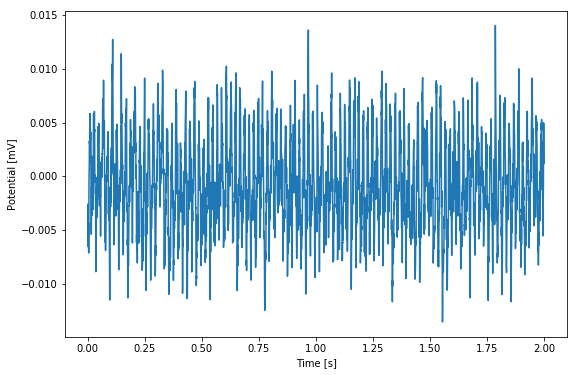

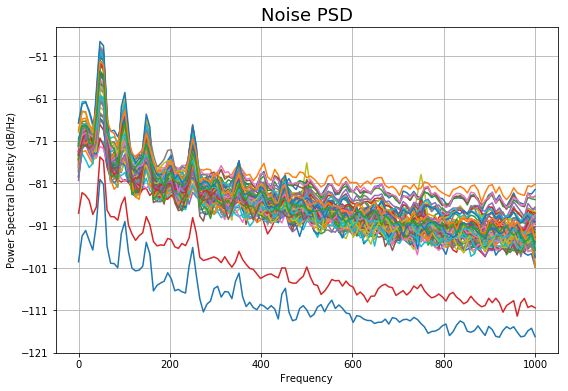

In [179]:
otb_folder = './tar/sessanta_flexor/'
xml_filename = '20191016104814.xml'
signal_filename = '20191016104814.sig'
mains_data = load_and_preprocess_data(otb_folder,xml_filename,signal_filename)
plot_data(mains_data[10,-2000*2:])
plot_psd(mains_data[:,-2000*2:])
plt.title("Noise PSD", fontSize=18)

## sessantaquattro without mains interference

Name : SESSANTAQUATTRO
DeviceTotalChannels : 66
Sources : 1
SampleFrequency : 2000
Firmware : Unknown
ad_bits : 16
shape (64, 178875)
max 2.4282025625000005 min -3.61367703125
max 2.410733314939073 min -1.9585348991244966


Text(0.5,1,'Noise PSD')

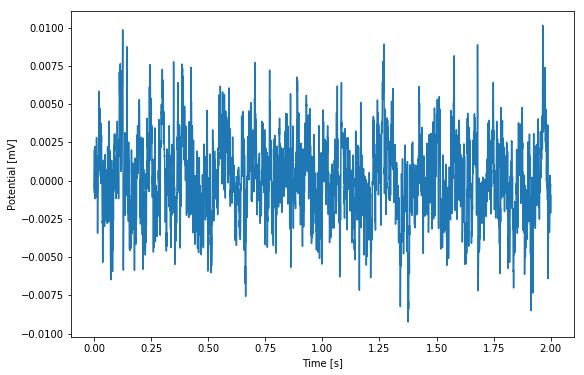

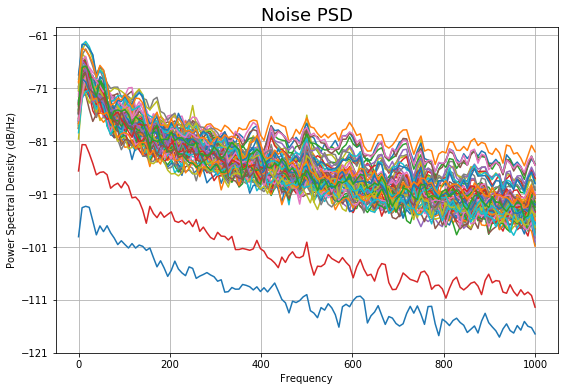

In [180]:
otb_folder = './tar/sessanta_flexor_no_mains/'
xml_filename = '20191016104814_01.xml'
signal_filename = '20191016104814_01.sig'

no_mains_data = load_and_preprocess_data(otb_folder,xml_filename,signal_filename)
plot_data(no_mains_data[10,-2000*2:])
plot_psd(no_mains_data[:,-2000*2:])
plt.title("Noise PSD [no mains]", fontSize=18,)

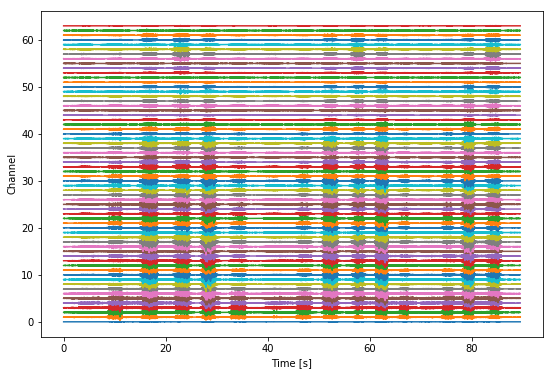

In [181]:
plot_data(no_mains_data)

## quattrocento with unshielded 4.3m data cable

Name : EMG-USB
ID : 255
DeviceTotalChannels : 64
Model : 30128
Sources : 1
SampleFrequency : 2048
Firmware : 2.14
ad_bits : 12
shape (64, 141824)
max 0.34564440625 min -0.3359516875
max 0.23872772695506478 min -0.24251499720583714


Text(0.5,1,'Noise PSD [quattro]')

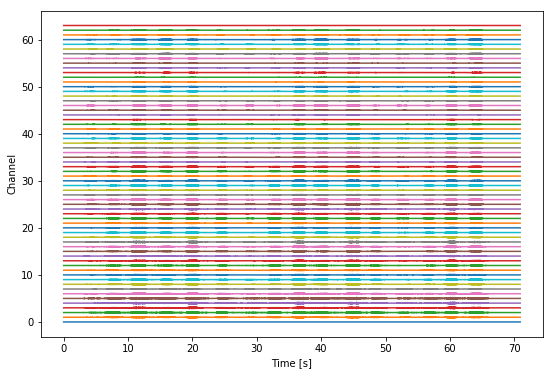

<Figure size 648x432 with 0 Axes>

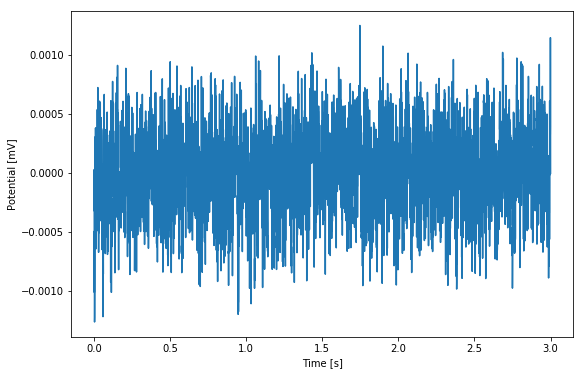

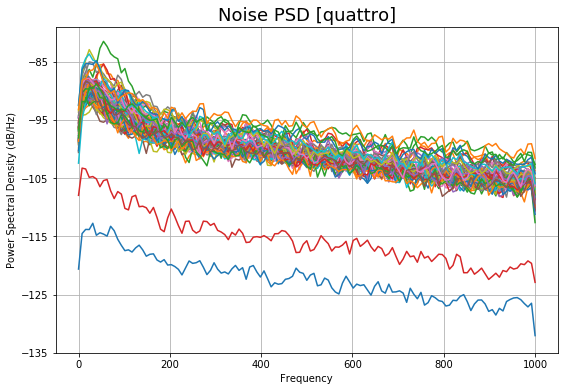

In [196]:
otb_folder = './tar/quattro/'
xml_filename = '20191016111452.xml'
signal_filename = '20191016111452.sig'

quattro_data = load_and_preprocess_data(otb_folder,xml_filename,signal_filename)
plot_data(quattro_data)
plt.figure()
plot_data(quattro_data[10,-2000*3:])
plot_psd(quattro_data[:,-2000*3:])
plt.title("Noise PSD [quattro]", fontSize=18,)

## PCA

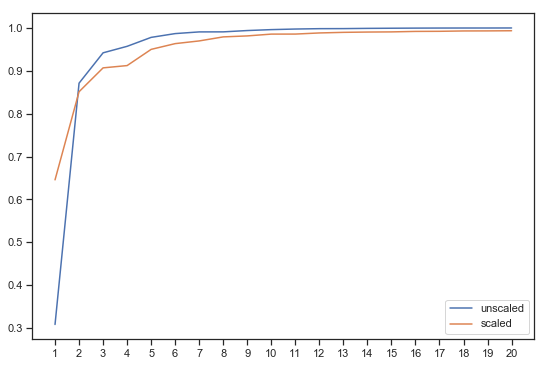

In [219]:
ncomps=20
scaler = StandardScaler()
no_mains_pca = PCA()

no_mains_pca.fit(no_mains_data.T)  
plt.plot(range(1,ncomps+1),1 - no_mains_pca.explained_variance_ratio_[:ncomps],label="unscaled")
plt.xticks(range(1,ncomps+1))

no_mains_scaled = scaler.fit_transform(no_mains_data)
no_mains_pca.fit(no_mains_scaled.T)  
plt.plot(range(1,ncomps+1),1 - no_mains_pca.explained_variance_ratio_[:ncomps],label="scaled")
plt.xticks(range(1,ncomps+1))
plt.legend()
plt.show()

## scaled

(178875, 3)


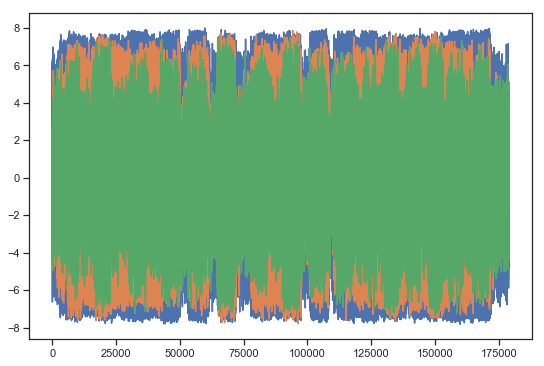

In [220]:
scaler = StandardScaler()
no_mains_scaled = scaler.fit_transform(no_mains_data)
no_mains_pca_low = PCA(n_components=3)
no_mains_data_low = no_mains_pca_low.fit_transform(no_mains_scaled.T) 
print(no_mains_data_low.shape)

for feature in no_mains_data_low.T:
    plt.plot(feature)

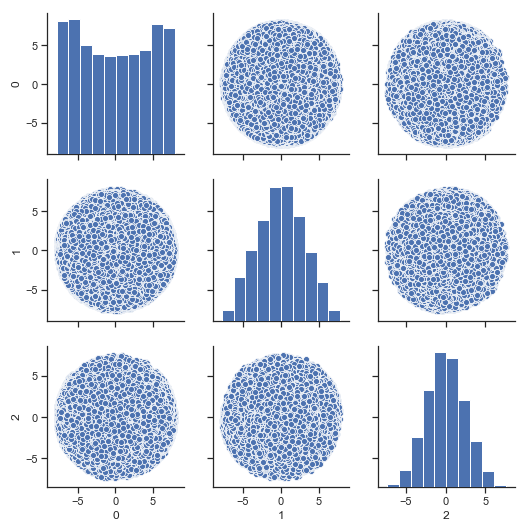

In [221]:
sns.set(style="ticks", color_codes=True)
_ = sns.pairplot(pd.DataFrame(no_mains_data_low))

## unscaled

(178875, 3)


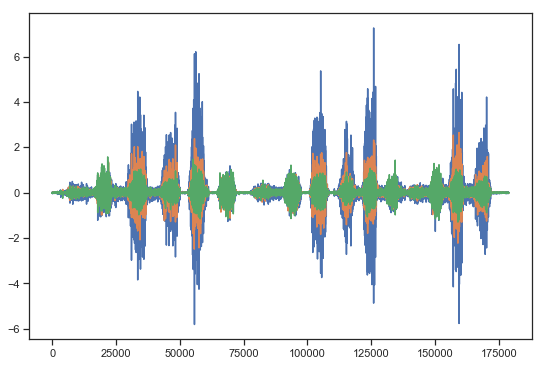

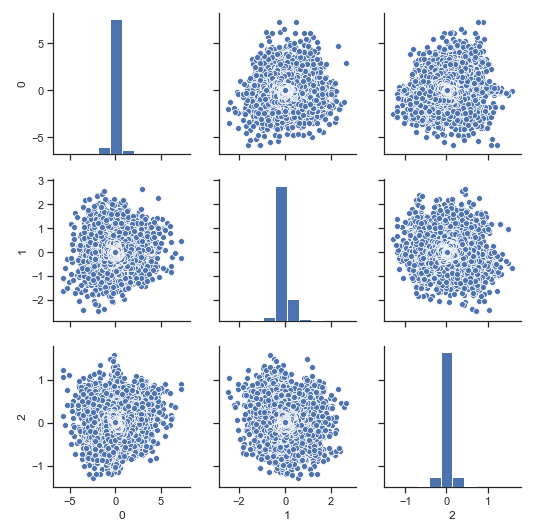

In [224]:
no_mains_pca_low = PCA(n_components=3)
no_mains_data_low = no_mains_pca_low.fit_transform(no_mains_data.T) 
print(no_mains_data_low.shape)

for feature in no_mains_data_low.T:
    plt.plot(feature)
    
sns.set(style="ticks", color_codes=True)
_ = sns.pairplot(pd.DataFrame(no_mains_data_low))

## Smoothing

In [225]:
CUTOFF = 10 #Hz
smoothed_data = np.zeros_like(no_mains_data)
for i, channel in enumerate(no_mains_data):
    smoothed_data[i, :] = lowpass(np.abs(channel), cutoff=CUTOFF)
smoothed_data = np.abs(smoothed_data)
np.min(smoothed_data)

2.403153812683307e-07

## PCA

(178875, 10)


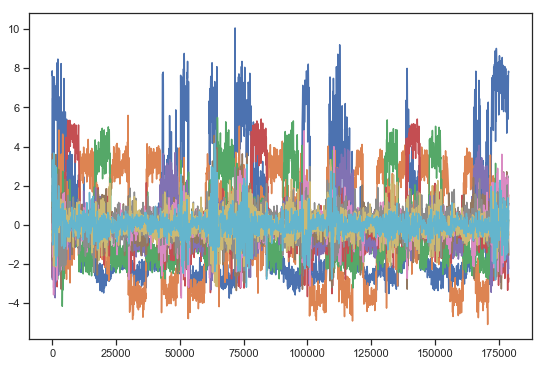

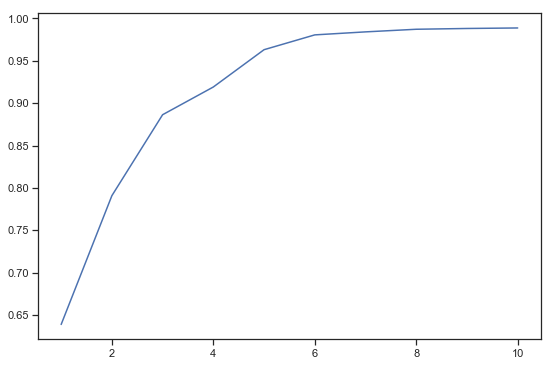

In [228]:
n = 10
scaler = StandardScaler()
smoothed_scaled = scaler.fit_transform(smoothed_data)
smoothed_pca = PCA(n_components=n)
smoothed_low = smoothed_pca.fit_transform(smoothed_scaled.T)  
print(smoothed_low.shape)
for feature in smoothed_low.T:
    plt.plot(feature)
plt.figure()
plt.plot(range(1,n+1),1-smoothed_pca.explained_variance_ratio_)

(178875, 10)


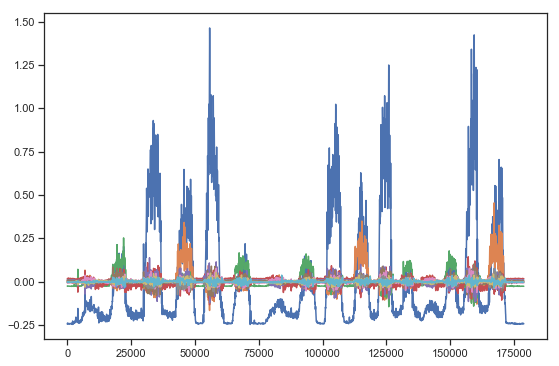

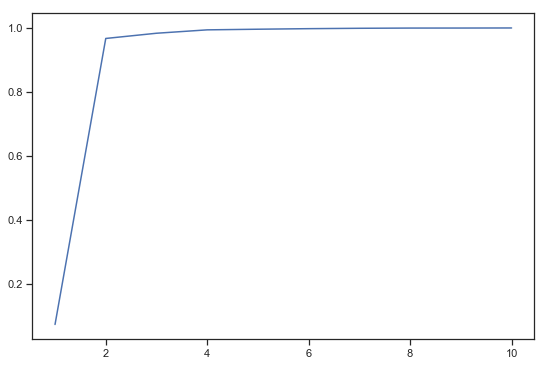

In [229]:
n = 10
smoothed_pca = PCA(n_components=n)
smoothed_low = smoothed_pca.fit_transform(smoothed_data.T)  
print(smoothed_low.shape)
for feature in smoothed_low.T:
    plt.plot(feature)
plt.figure()
plt.plot(range(1,n+1),1-smoothed_pca.explained_variance_ratio_)

## NMF

In [ ]:
from sklearn.decomposition import NMF

"""
Compute NMF for various numbers of components and record reconstruction MSE. 

"""
W_list = []
H_list = []
errors = []
for num_comps in range(1,10):
    model = NMF(n_components=num_comps, init='random', random_state=0)
    W_list.append(model.fit_transform(smoothed_data))
    H_list.append(model.components_)
    errors.append(model.reconstruction_err_)

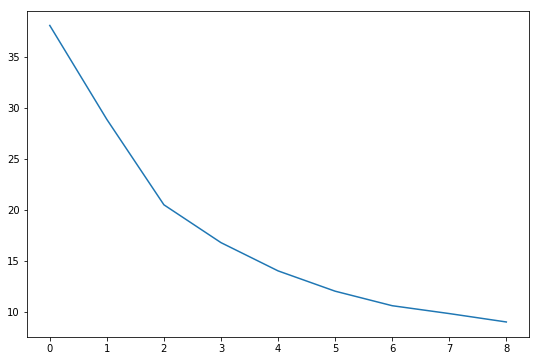

In [52]:
plt.plot(errors)
plt.title("NMF Error")
plt.xlabel("# Components")
plt.ylabel("Frobenius Norm Error")

## Electrode Layout

In [1]:
def grid_layout(data, grid_type = '8x8'):
    if len(data.shape) != 2:
        raise ValueError("data must be 2D")
    if grid_type == '8x8':
        pin_layout = np.array([
         [8, 16, 24, 32, 40, 48, 56, 64], 
         [7, 15, 23, 31, 39, 47, 55, 63],
         [6, 14, 22, 30, 38, 46, 54, 62],
         [5, 13, 21, 29, 37, 45, 53, 61],
         [4, 12, 20, 28, 36, 44, 52, 60],
         [3, 11, 19, 27, 35, 43, 51, 59],
         [2, 10, 18, 26, 34, 42, 50, 58],
         [1,  9, 17, 25, 33, 41, 49, 57]
         ])
        pin_layout = pin_layout-1
    k = data.shape[1] - 1
    output = np.zeros((pin_layout.shape[0],pin_layout.shape[1],k+1))
    for i, row in enumerate(pin_layout):
        for j, og_idx in enumerate(row):
            output[i,j,:] = data[og_idx,:]
    return output
weight_grid = grid_layout(np.arange(64).reshape(64,1))
plt.figure()
_ = plt.imshow(weight_grid[:,:,0])
_ = plt.colorbar()

NameError: name 'np' is not defined

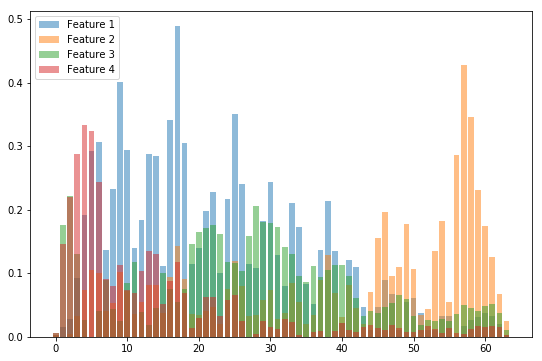

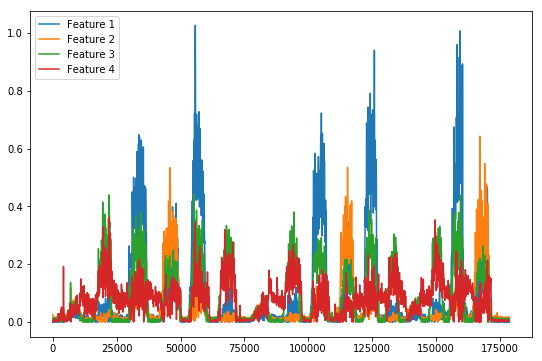

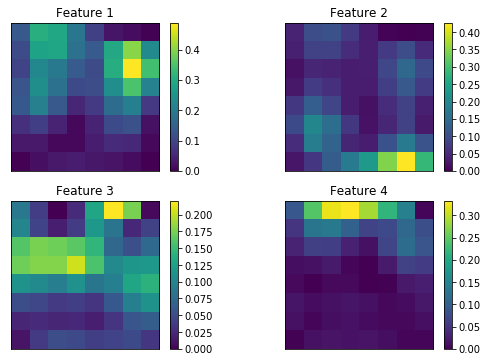

In [197]:
c = 3
rtimesc = '22'
plt.figure()
for i, feature in enumerate(W_list[c].T):
    _ = plt.bar(range(len(feature)), feature, alpha=0.5, label="Feature "+str(i+1))
    plt.legend()
    
plt.figure()
for i, factor in enumerate(H_list[c]):
    plt.plot(factor, label="Feature "+str(i+1))
plt.legend()

griddata = grid_layout(W_list[c])
fig = plt.figure()
for i, img in enumerate(griddata.T):
    ax = fig.add_subplot(rtimesc+str(i+1))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("Feature "+str(i+1))
    im = ax.imshow(img)
    plt.colorbar(im)